In [1]:
#Libraries

import numpy as np
np.set_printoptions(precision=9)
np.seterr(divide='ignore', invalid='ignore', over='ignore')                #dont print warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import mathieu_functions_OG as mf
import timeit
from datetime import timedelta
import flopy

# Input Data

In [2]:
#Parameter
alpha_l = 10              #longitudinal dispersivity (m)
alpha_t = 1               #horizontal tranverse dispersivity (m)

C0 = 10                   # donor concentration source 1 (mg/l)
C1 = 10                   # donor concentration source 2 (mg/l)
Ca = 8                    # acceptor concentration
gamma = 3.5               # stoichiometric ratio
r = 1                     # radius of the element

beta = 1/(2*alpha_l)
d = np.sqrt((r*np.sqrt(alpha_l/alpha_t))**2-r**2)
q = (d**2*beta**2)/4

n = 7                     #Number of terms in mathieu series
M = 100                   #Number of Control Points

# Single Element Model

In [3]:
#wrapper xy to eta psi
def uv(x, y):
    Y = np.sqrt(alpha_l/alpha_t)*y
    B = x**2+Y**2-d**2
    p = (-B+np.sqrt(B**2+4*d**2*x**2))/(2*d**2)
    q = (-B-np.sqrt(B**2+4*d**2*x**2))/(2*d**2)

    psi_0 = np.arcsin(np.sqrt(p))

    if Y >= 0 and x >= 0:
        psi = psi_0
    if Y < 0 and x >= 0:
        psi = np.pi-psi_0
    if Y <= 0 and x < 0:
        psi = np.pi+psi_0
    if Y > 0 and x < 0:
        psi = 2*np.pi-psi_0

    eta = 0.5*np.log(1-2*q+2*np.sqrt(q**2-q))
    return eta, psi

#polar coordinates
phi = np.linspace(0, 2*np.pi, M)
x1 = r*np.cos(phi)
y1 = r*np.sin(phi)

#elliptic coordinates
uv_vec = np.vectorize(uv)
psi1 = uv_vec(x1, y1)[1]
eta1 = uv_vec(x1, y1)[0]

#Mathieu Functions
m = mf.mathieu(q)

def Se(order, psi):                    #even angular first kind
    return m.ce(order, psi).real
def So(order, psi):                    #odd angular first kind
    return m.se(order, psi).real
def Ye(order, eta):                    #even radial second Kind
    return m.Ke(order, eta).real
def Yo(order, eta):                    #odd radial second Kind
    return m.Ko(order, eta).real

#Target Function
def F1(x1):
    return (C0*gamma+Ca)*np.exp(-beta*x1)

#System of Equations to calculate coefficients
lst = []                                                                        #empty array

for i in range(0, M):                                                            #filling array with all terms of MF for the source
    for j in range(0, 1):
        lst.append(Se(j, psi1[i])*Ye(j, eta1[i]))
    for j in range(1, n):
        lst.append(So(j, psi1[i])*Yo(j, eta1[i]))
        lst.append(Se(j, psi1[i])*Ye(j, eta1[i]))

F_M = []
s = 2*n-1
for k in range(0, len(lst), s):                                                   #appending each line (s elements) as arrays (in brackets) -> achieve right array structure (list of arrays)
    F_M.append(lst[k:k+s])

F = []

for u in range(0, M):                                                            #target function vector
    F.append(F1(x1[u])) #

Coeff = np.linalg.lstsq(F_M, F, rcond=None)                                       #calculated coefficients and residual
print(Coeff[0])

#comprehensive solution
def c_single(x, y):
    if (x**2+y**2)<=r**2:
        return C0
    eta = uv(x, y)[0]
    psi = uv(x, y)[1]

    F = Coeff[0][0]*Se(0, psi)*Ye(0, eta)
    for w in range(1, n):
        F += Coeff[0][2*w-1]*So(w, psi)*Yo(w, eta) \
            + Coeff[0][2*w]*Se(w, psi)*Ye(w, eta)

    return (F*np.exp(beta*x)).round(9)
    #here the backtransformation is already applied -> tranforming from the C-domain into the C_D and C_A domain
    #if ((F*np.exp(beta*x)))> Ca:                                        
    #    return ((((F*np.exp(beta*x)))-Ca)/gamma).round(9)
    #else:
    #    return ((((F*np.exp(beta*x)))-Ca)).round(9)

[ 1.806154888e+01 -2.261963141e-01  6.021387816e-15  2.029819645e-15
 -8.018802016e-04  7.351344817e-07 -1.009761808e-18  5.944477975e-18
  6.887390100e-11 -4.202600724e-14 -2.522810868e-24 -5.777041837e-21
  0.000000000e+00]


# Computation of Concentration array in required domain extent

In [4]:
# concentration array for plotting purpose
inc = 0.1

def Conc_array(x_min, x_max, y_min, y_max, inc):
    xaxis = np.arange(x_min, x_max, inc)
    yaxis = np.arange(y_min, y_max, inc)
    X, Y = np.meshgrid(xaxis, yaxis)
    v = np.vectorize(c_single)
    Conc = v(X, Y)
    return xaxis, yaxis, Conc

# single-core processing
start = timeit.default_timer()
result = Conc_array(-5, 10.1, -3, 3.1, inc)    # <---- insert domain extent here
stop = timeit.default_timer()
sec = int(stop - start)
cpu_time = timedelta(seconds = sec)
print('Computation time [hh:mm:ss]:', cpu_time)

Computation time [hh:mm:ss]: 0:00:09


# Plotting Results

## Plume

C:\Users\Anton\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\Anton\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\Anton\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


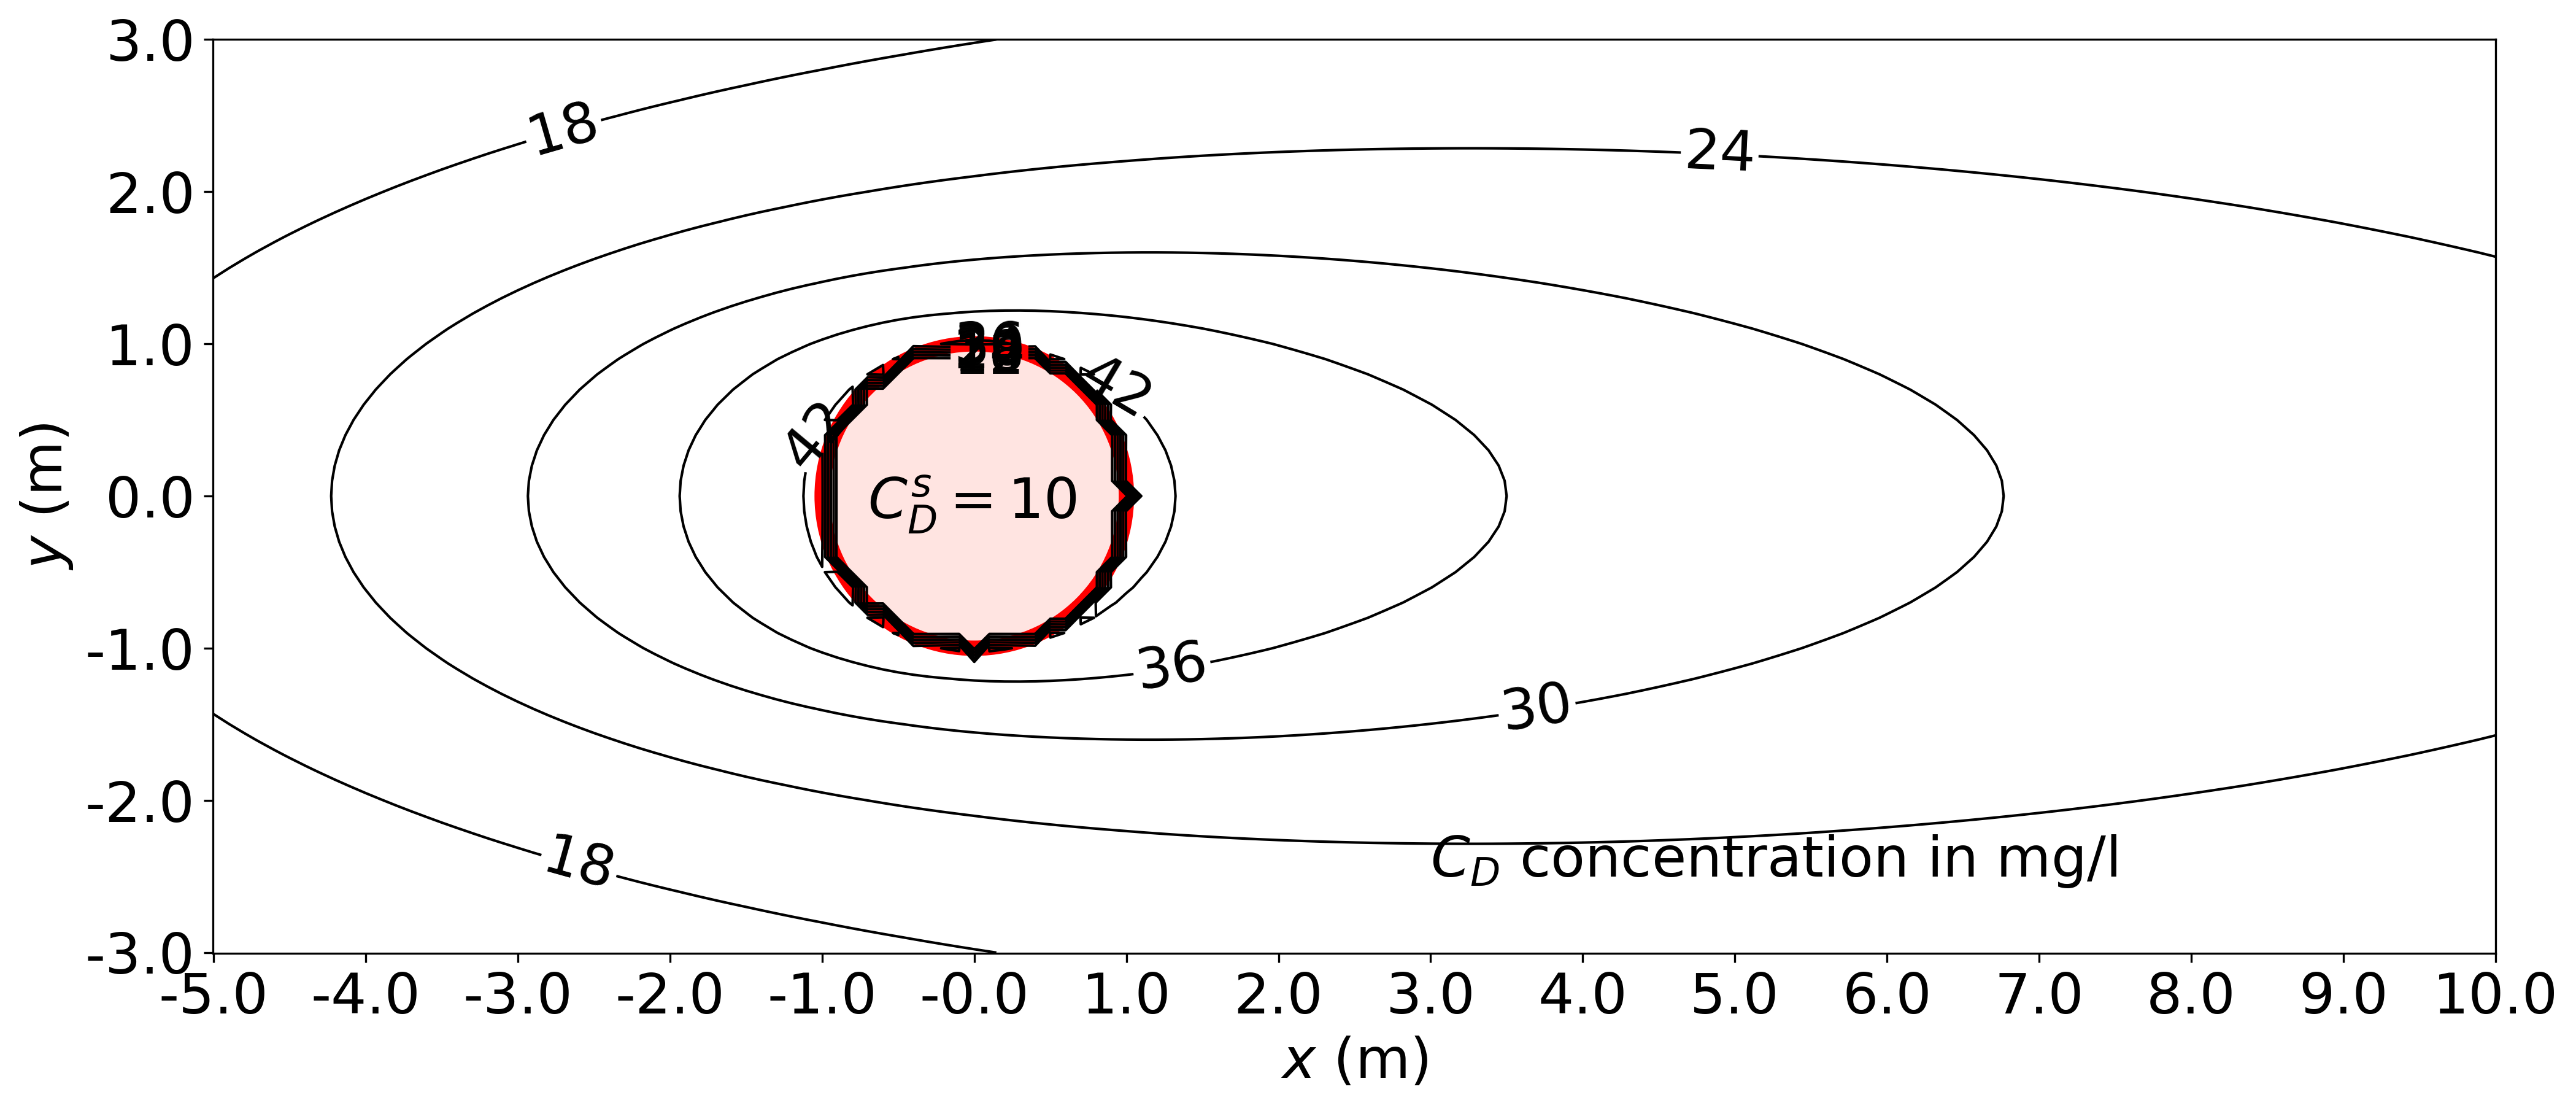

In [5]:
plt.figure(figsize=(16, 16*(len(result[1])/len(result[0]))), dpi = 300)
mpl.rcParams.update({'font.size': 22})
plt.axis('scaled')
#plt.grid()
#plt.xlim([0,150])
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.xticks(range(len(result[0]))[::int(1/inc)], result[0][::int(1/inc)].round())
plt.yticks(range(len(result[1]))[::int(1/inc)], result[1][::int(1/inc)].round())
#Plume = plt.contourf(result[2], levels=np.linspace(Ca, 43, 5), cmap='binary') #levels=[0], , colors='k'
Plume_max = plt.contour(result[2], levels=5, linewidths=1, colors='k') #colors='k'
Plume_max.clabel(inline=True, colors = 'k')
plt.text(80,5,r'$C_D$ concentration in mg/l')
plt.text(43,28.5,r'$C_D^s = 10$')
Source = plt.Circle((50, 30), 10, edgecolor='red', facecolor='mistyrose', linewidth = 6, fill=True)
plt.gca().add_patch(Source)


#Colorbar
# norm= mpl.colors.Normalize(vmin=Plume.cvalues.min(), vmax=Plume.cvalues.max())
# sm = plt.cm.ScalarMappable(norm=norm, cmap = Plume.cmap)
# sm.set_array([])
# plt.colorbar(Plume, ticks=Plume.levels, label='Concentration (mg/l)', location='bottom', shrink=0.8)

# Label = '$C_{D}=C_{A}=0$'
# Lmax = Plume.get_paths()[0]
# plt.clabel(Plume, fmt=Label, manual = [(50,-(2*np.max(result[1])))])
# print('Lmax =',int(np.max(Lmax.vertices[:,int((result[1][0]+result[1][-1])/2)])*inc-np.abs(result[0][0])))
# textbox = r'$L_{max} = $' + str(int(np.max(Lmax.vertices[:,int((result[1][0]+result[1][-1])/2)])*inc-np.abs(result[0][0]))) + ' m'
# plt.text(20,2*np.max(result[1])-10,textbox)

In [6]:
# concentration array for plotting purpose
inc = 1

def Conc_array(x_min, x_max, y_min, y_max, inc):
    xaxis = np.arange(x_min, x_max, inc)
    yaxis = np.arange(y_min, y_max, inc)
    X, Y = np.meshgrid(xaxis, yaxis)
    v = np.vectorize(c_single)
    Conc = v(X, Y)
    return xaxis, yaxis, Conc

# single-core processing
start = timeit.default_timer()
result = Conc_array(-20, 151, -20, 21, inc)    # <---- insert domain extent here
stop = timeit.default_timer()
sec = int(stop - start)
cpu_time = timedelta(seconds = sec)
print('Computation time [hh:mm:ss]:', cpu_time)

Computation time [hh:mm:ss]: 0:00:07


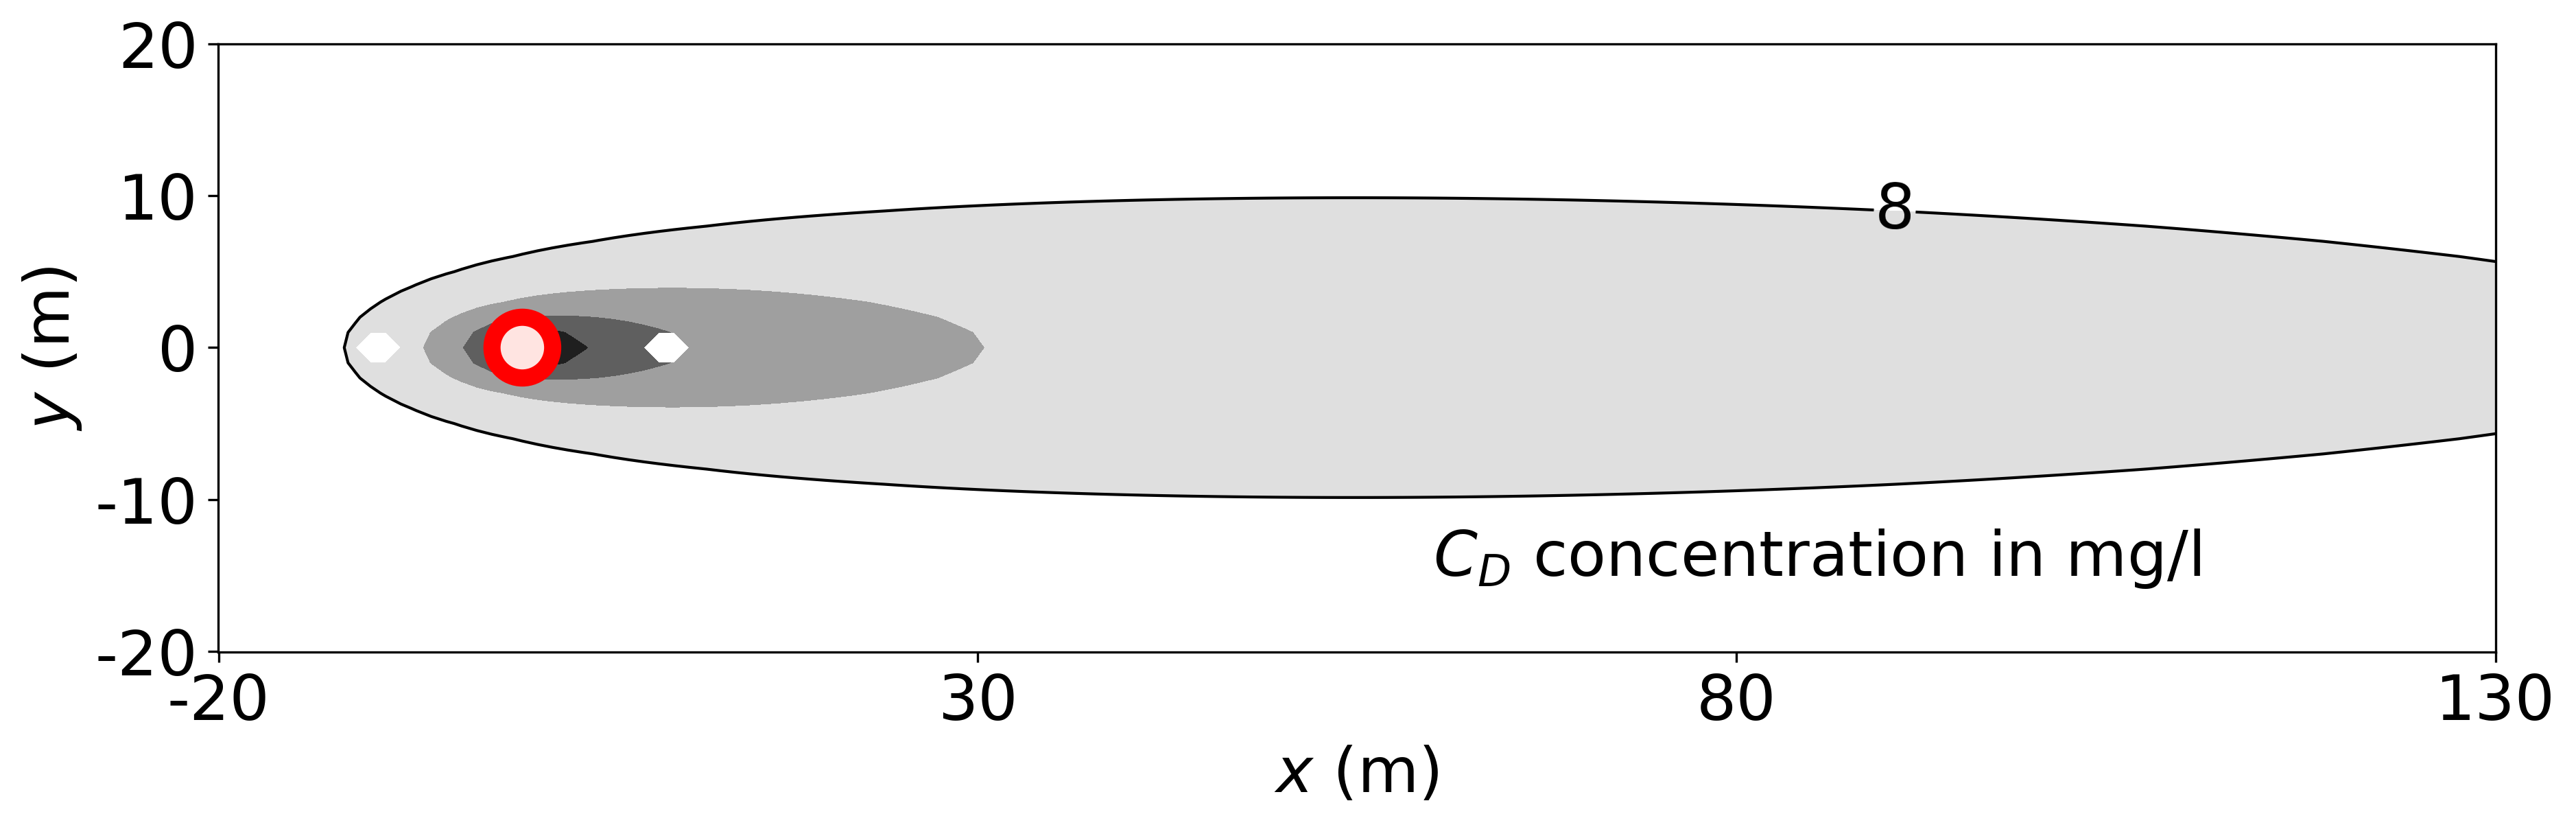

In [7]:
plt.figure(figsize=(16, 16*(len(result[1])/len(result[0]))), dpi = 300)
mpl.rcParams.update({'font.size': 22})
plt.axis('scaled')
#plt.grid()
#plt.xlim([0,150])
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.xticks(range(len(result[0]))[::int(50/inc)], result[0][::int(50/inc)].round())
plt.yticks(range(len(result[1]))[::int(10/inc)], result[1][::int(10/inc)].round())
Plume = plt.contourf(result[2], levels=np.linspace(Ca, 43, 5), cmap='binary') #levels=[0], , colors='k'
Plume_max = plt.contour(result[2], levels=[Ca], linewidths=1, colors='k') #colors='k'
#Plume_max.clabel(inline=True, colors = 'k')
plt.text(80,5,r'$C_D$ concentration in mg/l')
#plt.text(43,28.5,r'$C_D^s = 10$')
Source = plt.Circle((20, 20), 1, edgecolor='red', facecolor='mistyrose', linewidth = 6, fill=True)
plt.gca().add_patch(Source)

## Error along Boundary

Min = 10.0 mg/l
Max = 43.000000006 mg/l
Mean = 10.733333333 mg/l
Standard Deviation = 4.864383026370508 mg/l


(0.0, 6.283185307179586)

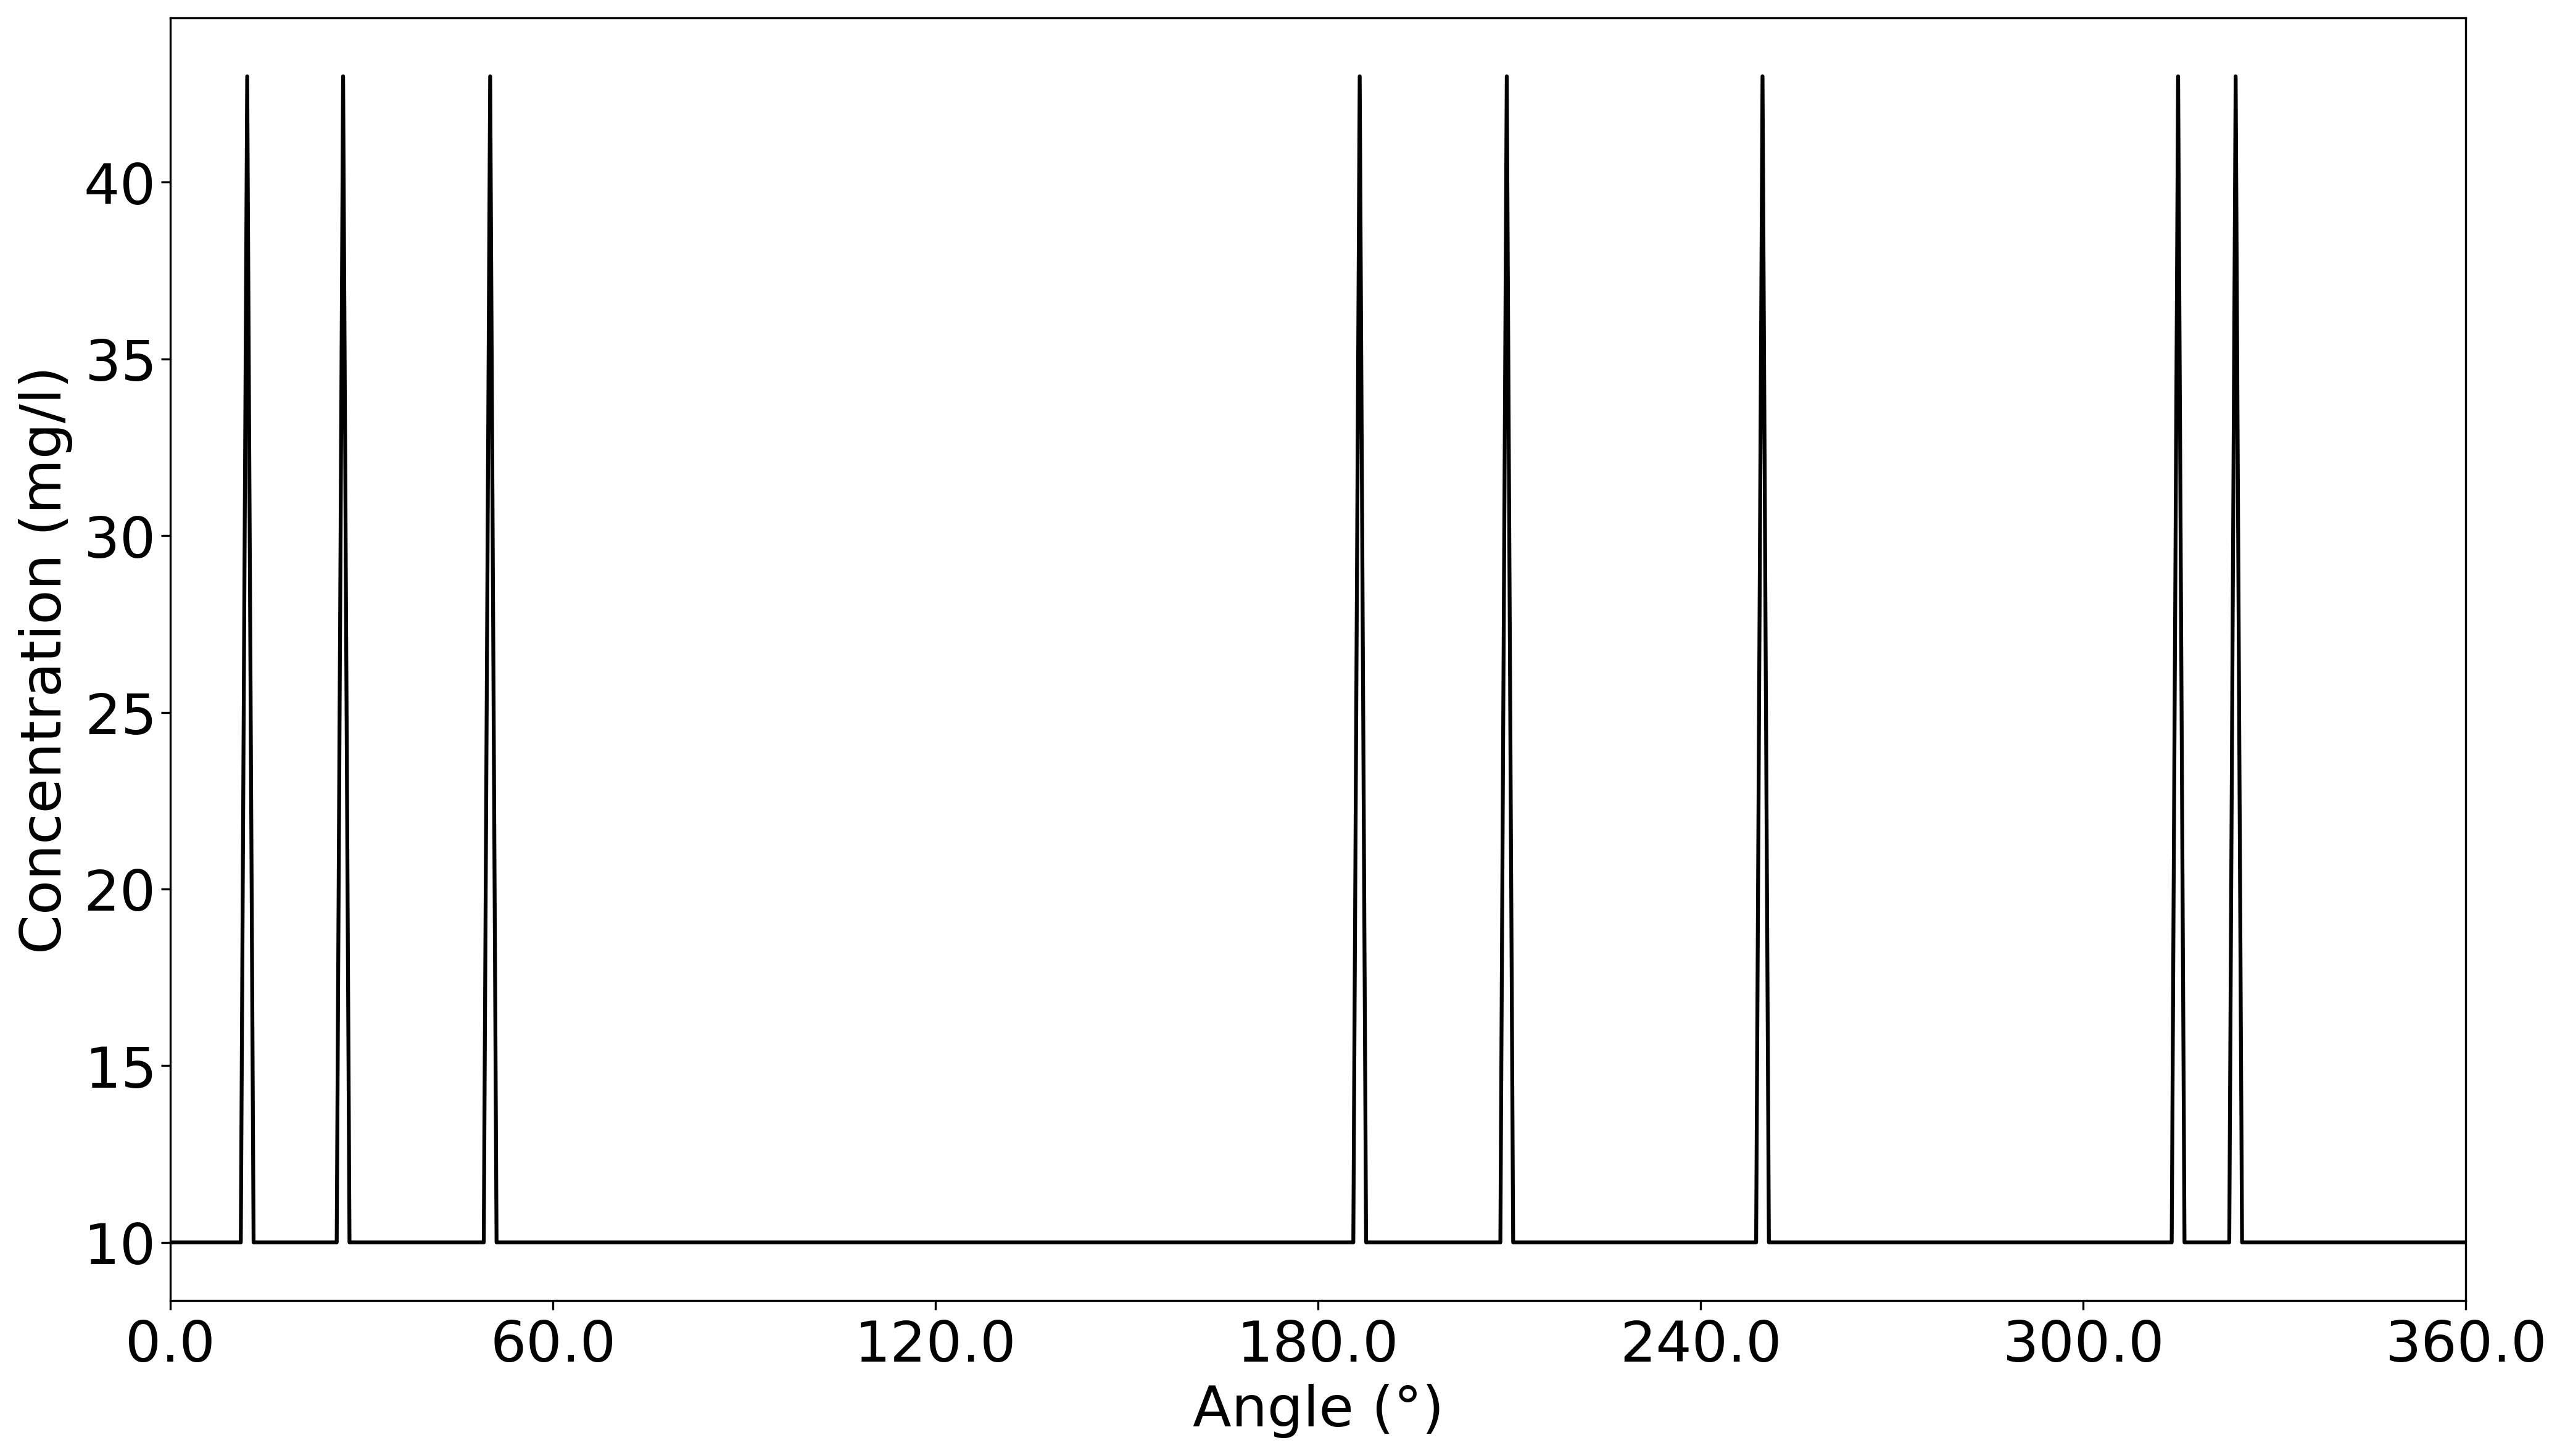

In [8]:
#absolut error [mg/l]
phi2 = np.linspace(0, 2*np.pi, 360)
x_test = (r) * np.cos(phi2)
y_test = (r) * np.sin(phi2)

Err = []
for i in range(0, 360, 1):
    Err.append((c_single(x_test[i], y_test[i])))
#print(Err)
print('Min =', np.min(Err).round(9), 'mg/l')
print('Max =', np.max(Err).round(9), 'mg/l')
print('Mean =', np.mean(Err).round(9), 'mg/l')
print('Standard Deviation =', np.std(Err).round(15), 'mg/l')

plt.figure(figsize=(16,9), dpi=300)
mpl.rcParams.update({'font.size': 22})
plt.plot(phi2, Err, color='k')
plt.xlabel('Angle (°)')
plt.ylabel('Concentration (mg/l)')
plt.ticklabel_format(axis='both', style='scientific', useMathText=True, useOffset=True, scilimits=(0,2))
plt.xticks(np.linspace(0, 2*np.pi, 7), np.linspace(0, 360, 7))
plt.xlim([0, 2*np.pi])
# min_text = 'Min = ' + str(np.min(Err).round(9)) + ' mg/l'
# max_text = 'Max = ' + str(np.max(Err).round(9)) + ' mg/l'
# mean_text = 'Mean = ' + str(np.mean(Err).round(9)) + ' mg/l'
# std_text = 'Standard Deviation = '+ str(np.std(Err).round(9)) + ' mg/l'
# plt.text(0.8, 43+1e-8, min_text)
# plt.text(0.8, 43+9e-9, max_text)
# plt.text(0.8, 43+8e-9, mean_text)
# plt.text(0.8, 43+7e-9, std_text)
# rectangle = mpl.patches.Rectangle((0.75, 43+6.5e-9), 2.75, 4.75e-9, color='lightgrey', linewidth=3)
# plt.gca().add_patch(rectangle)

## Central Difference Approximation

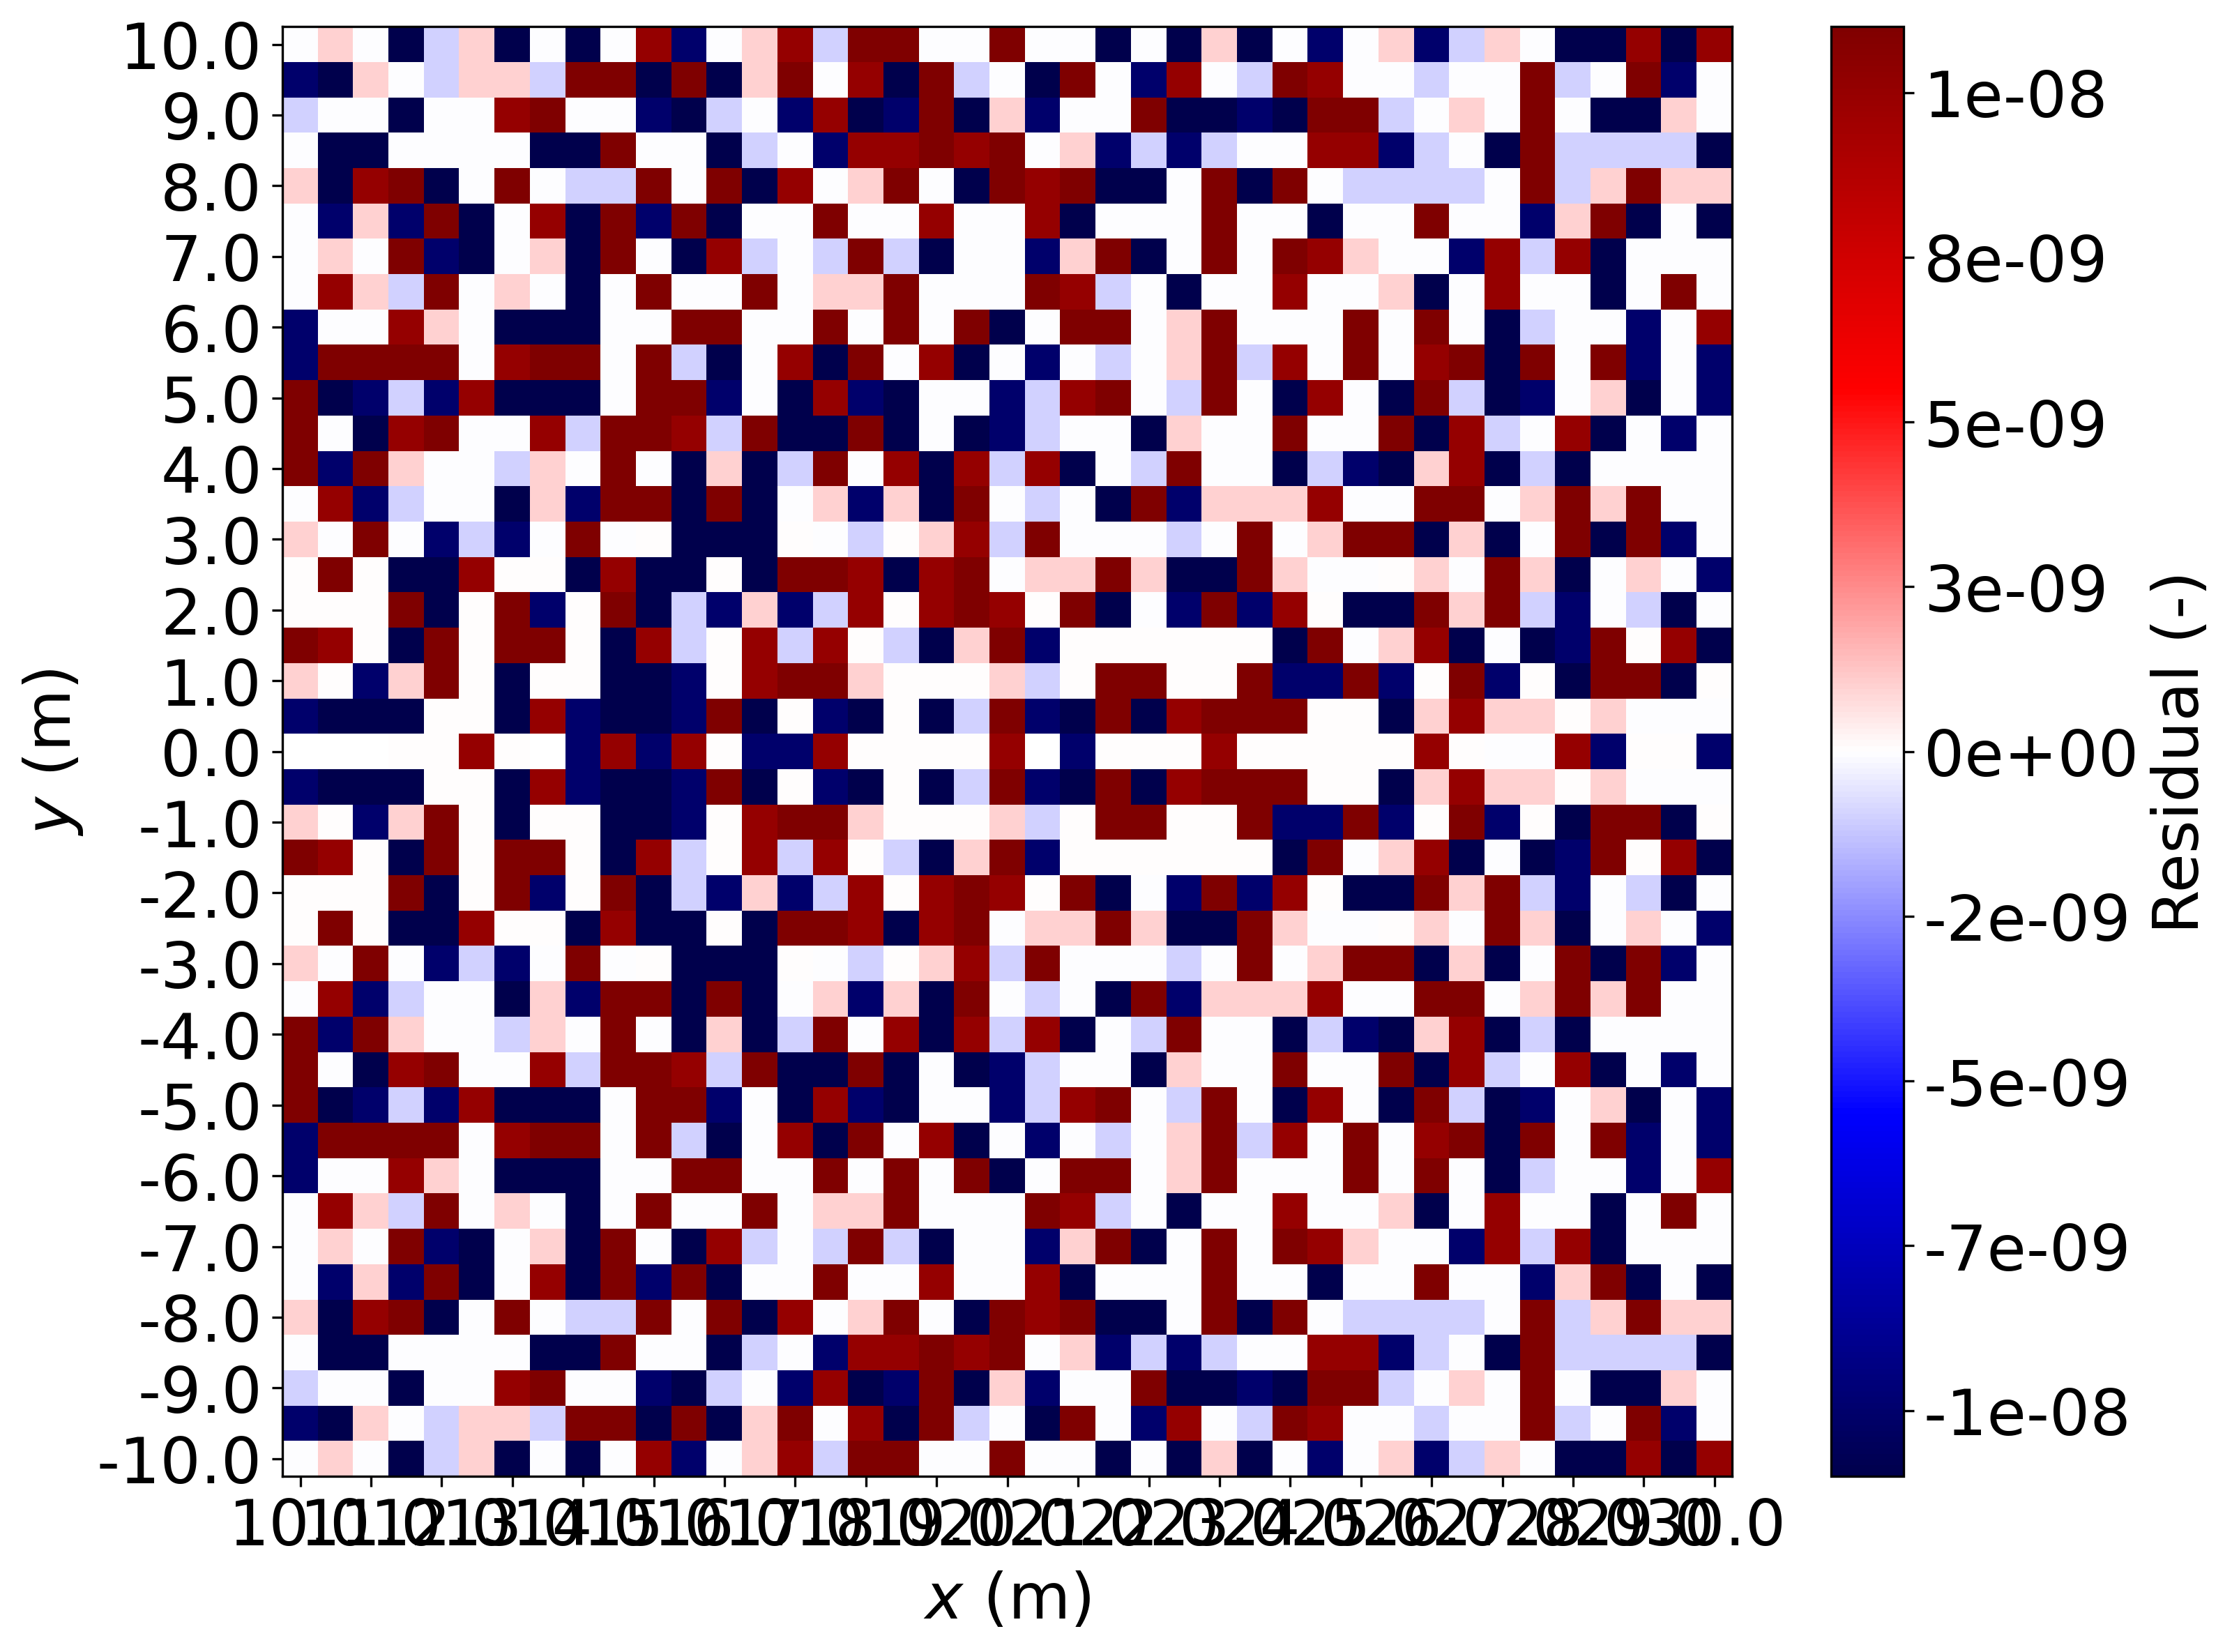

In [9]:
#Central Difference Approximation

def R(x_min, x_max, y_min, y_max, inc):
    dh = 1e-6
    xaxis = np.arange(x_min, x_max, inc)
    yaxis = np.arange(y_min, y_max, inc)
    X, Y = np.meshgrid(xaxis, yaxis)
    cd = np.vectorize(c_single)
    approx = (alpha_l*(cd(X-dh,Y)-2*cd(X,Y)+cd(X+dh,Y)) + alpha_t*(cd(X,Y-dh)-2*cd(X,Y)+cd(X,Y+dh)) - dh*(cd(X+dh,Y)-cd(X,Y)))
    return xaxis, yaxis, approx

result2 = R(10,30.5,-10,10.5,0.5)

#Error
mpl.rcParams.update({'font.size': 22})
plt.figure(figsize=(16,9), dpi=300)
plt.xticks(range(len(result2[0]))[::int(2/inc)], result2[0][::int(2/inc)].round())
plt.yticks(range(len(result2[1]))[::int(5/inc)], result2[1][::int(5/inc)].round())
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
#plt.axhline((len(y)-1)/2, linestyle='--', color='black', linewidth=1)
norm = mpl.colors.Normalize(vmin=np.nanmin(result2[2]), vmax=np.nanmax(result2[2]))
plt.imshow(result2[2], cmap='seismic', norm=norm, origin='lower')
plt.colorbar(format='%.0e', label='Residual (-)', fraction=0.046, pad=0.038)

# Two Element Model

In [10]:
#Mathieu Functions
m = mf.mathieu(q)

#Real Mathieu Functions
def Se(order, psi):                    #even angular first kind
    return m.ce(order, psi).real
def So(order, psi):                    #odd angular first kind
    return m.se(order, psi).real
def Ye(order, eta):                    #even radial second Kind
    return m.Ke(order, eta).real
def Yo(order, eta):                    #odd radial second Kind
    return m.Ko(order, eta).real

#wrapper xy to eta psi
def uv(x, y):
    Y = np.sqrt(alpha_l/alpha_t)*y
    B = x**2+Y**2-d**2
    p = (-B+np.sqrt(B**2+4*d**2*x**2))/(2*d**2)
    q = (-B-np.sqrt(B**2+4*d**2*x**2))/(2*d**2)

    psi_0 = np.arcsin(np.sqrt(p))
    if Y >= 0 and x >= 0:
        psi = psi_0
    if Y < 0 and x >= 0:
        psi = np.pi-psi_0
    if Y <= 0 and x < 0:
        psi = np.pi+psi_0
    if Y > 0 and x < 0:
        psi = 2*np.pi-psi_0
    eta = 0.5*np.log(1-2*q+2*np.sqrt(q**2-q))
    return eta, psi

#polar coordinates
phi = np.linspace(0, 2*np.pi, M)
x1 = r*np.cos(phi)
y1 = r*np.sin(phi)

#source coordinates xy and distance of second source
D1 = 50
D2 = 20
x2 = x1 - D1
y2 = y1 - D2
x3 = x1 + D1
y3 = y1 + D2

#source coordinates eta psi
uv_vec = np.vectorize(uv)
psi1 = uv_vec(x1, y1)[1]
psi2 = uv_vec(x2, y2)[1]
psi3 = uv_vec(x3, y3)[1]
eta1 = uv_vec(x1, y1)[0]
eta2 = uv_vec(x2, y2)[0]
eta3 = uv_vec(x3, y3)[0]

#%%
#general target function:
def F_target(x, Ci):
    if Ci > 0:
        return (Ci*gamma+Ca)*np.exp(-beta*x), (Ci*gamma+Ca), 'r'
    if Ci <= 0:
        return (Ci)*np.exp(-beta*x), (Ci), 'b'

#System of Equations to calculate coefficients
#"perspective" source 1
lst = []                                #empty array

for i in range(0, M):                                    #filling array with all terms of MF for 1st source
    for j in range(0, 1):
        lst.append(Se(j, psi1[i])*Ye(j, eta1[i]))
    for j in range(1, n):
        lst.append(So(j, psi1[i])*Yo(j, eta1[i]))
        lst.append(Se(j, psi1[i])*Ye(j, eta1[i]))
    for j in range(0, 1):                                #filling array with all terms of MF for 2nd source
        lst.append(Se(j, psi2[i])*Ye(j, eta2[i]))
    for j in range(1, n):
        lst.append(So(j, psi2[i])*Yo(j, eta2[i]))
        lst.append(Se(j, psi2[i])*Ye(j, eta2[i]))

F_M1 = []
s = (2*n-1)*2
for k in range(0, len(lst), s):           #appending each line (s elements) as arrays (in brackets) -> achieve right array structure (list of arrays)
    F_M1.append(lst[k:k+s])

#"perspective" source 2
lst2 = []

for i in range(0, M):
    for j in range(0, 1):                                   #filling array with all terms of MF for 1st source
        lst2.append(Se(j, psi3[i])*Ye(j, eta3[i]))
    for j in range(1, n):
        lst2.append(So(j, psi3[i])*Yo(j, eta3[i]))
        lst2.append(Se(j, psi3[i])*Ye(j, eta3[i]))
    for j in range(0, 1):                                   #filling array with all terms of MF for 2nd source
        lst2.append(Se(j, psi1[i])*Ye(j, eta1[i]))
    for j in range(1, n):
        lst2.append(So(j, psi1[i])*Yo(j, eta1[i]))
        lst2.append(Se(j, psi1[i])*Ye(j, eta1[i]))

#%%
F_M2 = []
s = (2*n-1)*2
for k in range(0, len(lst2), s):          #appending each line (s elements) as lists (in brackets) -> achieve right array structure (list of arrays)
    F_M2.append(lst2[k:k+s])

F_M = F_M1 + F_M2                       #combining arrays for "perspective"" 1 and 2

F = []                                  #target function vector

for u in range(0, M):
    F.append(F_target(x1[u], C0)[0])
for v in range(0, M):
    F.append(F_target(x3[v], C1)[0])

Coeff = np.linalg.lstsq(F_M, F, rcond=None)
#print(Coeff[0])

#%%
def c_multi(x, y):
    if (x**2+y**2)<=r**2:
        return F_target(x1[u], C0)[1]
    if ((x-D1)**2+(y-D2)**2)<=r**2:
        return F_target(x3[v], C1)[1]

    psi = uv(x, y)[1]
    eta = uv(x, y)[0]
    psi2 = uv(x-D1, y-D2)[1]
    eta2 = uv(x-D1, y-D2)[0]

    F1 = Coeff[0][0]*Se(0, psi)*Ye(0, eta)
    for w in range(1, n):
        F1 += Coeff[0][2*w-1]*So(w, psi)*Yo(w ,eta) \
            + Coeff[0][2*w]*Se(w, psi)*Ye(w, eta)

    F2 = Coeff[0][2*n-1]*Se(0, psi2)*Ye(0, eta2)
    for b in range(1, n):
        F2 += Coeff[0][(2*n-1)+(2*b-1)]*So(b, psi2)*Yo(b, eta2) \
            + Coeff[0][(2*n-1)+(2*b)]*Se(b, psi2)*Ye(b, eta2)                   #till here F domain

    return (F1*np.exp(beta*x) + F2*np.exp(beta*x)).round(9)              #from here C domain

    # if ((F*np.exp(beta*x)))> Ca:
    #     return ((((F*np.exp(beta*x)))-Ca)/gamma).round(9)
    # else:
    #     return ((((F*np.exp(beta*x)))-Ca)).round(9)

# Computation of Concentration array in required domain extent

In [11]:
# concentration array for plotting purpose
inc = 1

def Conc_array(x_min, x_max, y_min, y_max, inc):
    xaxis = np.arange(x_min, x_max, inc)
    yaxis = np.arange(y_min, y_max, inc)
    X, Y = np.meshgrid(xaxis, yaxis)
    v = np.vectorize(c_multi)
    Conc = v(X, Y)
    return xaxis, yaxis, Conc

# single-core processing
start = timeit.default_timer()
result = Conc_array(-20, 551, -30, 51, inc)
stop = timeit.default_timer()
sec = int(stop - start)
cpu_time = timedelta(seconds = sec)
print('Computation time [hh:mm:ss]:', cpu_time)

Computation time [hh:mm:ss]: 0:01:40


# Plotting Results

## Plume

C:\Users\Anton\AppData\Local\Temp\ipykernel_439596\489105652.py:10: UserWarning: linewidths is ignored by contourf
  Plume = plt.contourf(result[2], levels=np.linspace(Ca, 43, 10), linewidths=2, cmap='binary')


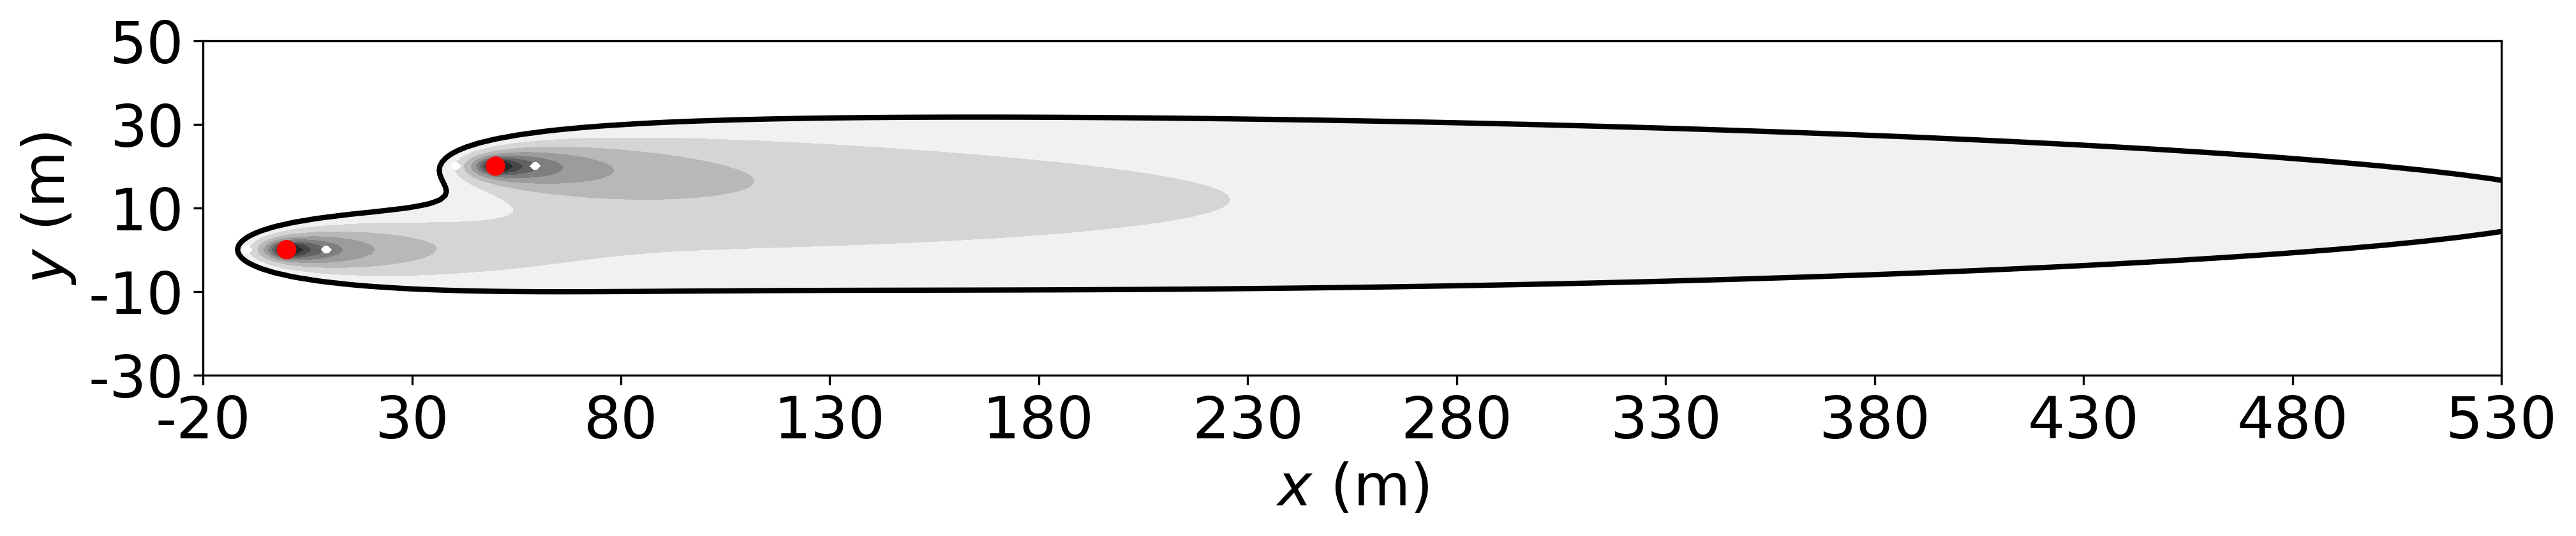

In [12]:
plt.figure(figsize=(16, 16*(len(result[1])/len(result[0]))), dpi = 300)
mpl.rcParams.update({'font.size': 22})
#plt.axis('equal')
plt.axis('scaled')
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')

plt.xticks(range(len(result[0]))[::int(50/inc)], result[0][::int(50/inc)])
plt.yticks(range(len(result[1]))[::int(20/inc)], result[1][::int(20/inc)])
Plume = plt.contourf(result[2], levels=np.linspace(Ca, 43, 10), linewidths=2, cmap='binary')
Plume_max = plt.contour(result[2], levels=[Ca], linewidths=2, colors='k')

Source0 = plt.Circle((result[0].tolist().index(0), result[1].tolist().index(0)), 2, color = F_target(x1[u], C0)[2])         #adding circles in the plot
Source1 = plt.Circle((result[0].tolist().index(0)+D1, result[1].tolist().index(0)+D2), 2, color = F_target(x3[v], C1)[2])   #adding circles in the plot
plt.gca().add_patch(Source0)
plt.gca().add_patch(Source1)

# #Colorbar
# norm= mpl.colors.Normalize(vmin=Plume.cvalues.min(), vmax=Plume.cvalues.max())
# sm = plt.cm.ScalarMappable(norm=norm, cmap = Plume.cmap)
# sm.set_array([])
# plt.colorbar(Plume, ticks=Plume.levels, label='Concentration [mg/l]')

# Label = '$C_{D}=C_{A}=0$'
# Lmax = Plume.get_paths()[0]
# #plt.clabel(Plume, fmt=Label, manual = [(50, -(2*np.max(result[1])*inc-np.abs(result[0][0])))])
# #print('Lmax =', int(np.max(Lmax.vertices[:, int((result[1][0]+result[1][-1])/2)])*inc-np.abs(result[0][0]))) #
# textbox = r'$L_{max} = 549 m$' #+ str(int(np.max(Lmax.vertices[:, int((result[1][0]+result[1][-1])/2)])*inc-np.abs(result[0][0]))) + ' m'
# plt.text(200, 30, textbox)

## Error

Min = 9.999999927
Max = 10.000000055
Mean = 10.0
Standard Deviation = 7e-09
Min2 = 9.999999997
Max2 = 10.000000004
Mean2 = 10.0
Standard Deviation2 = 1e-09


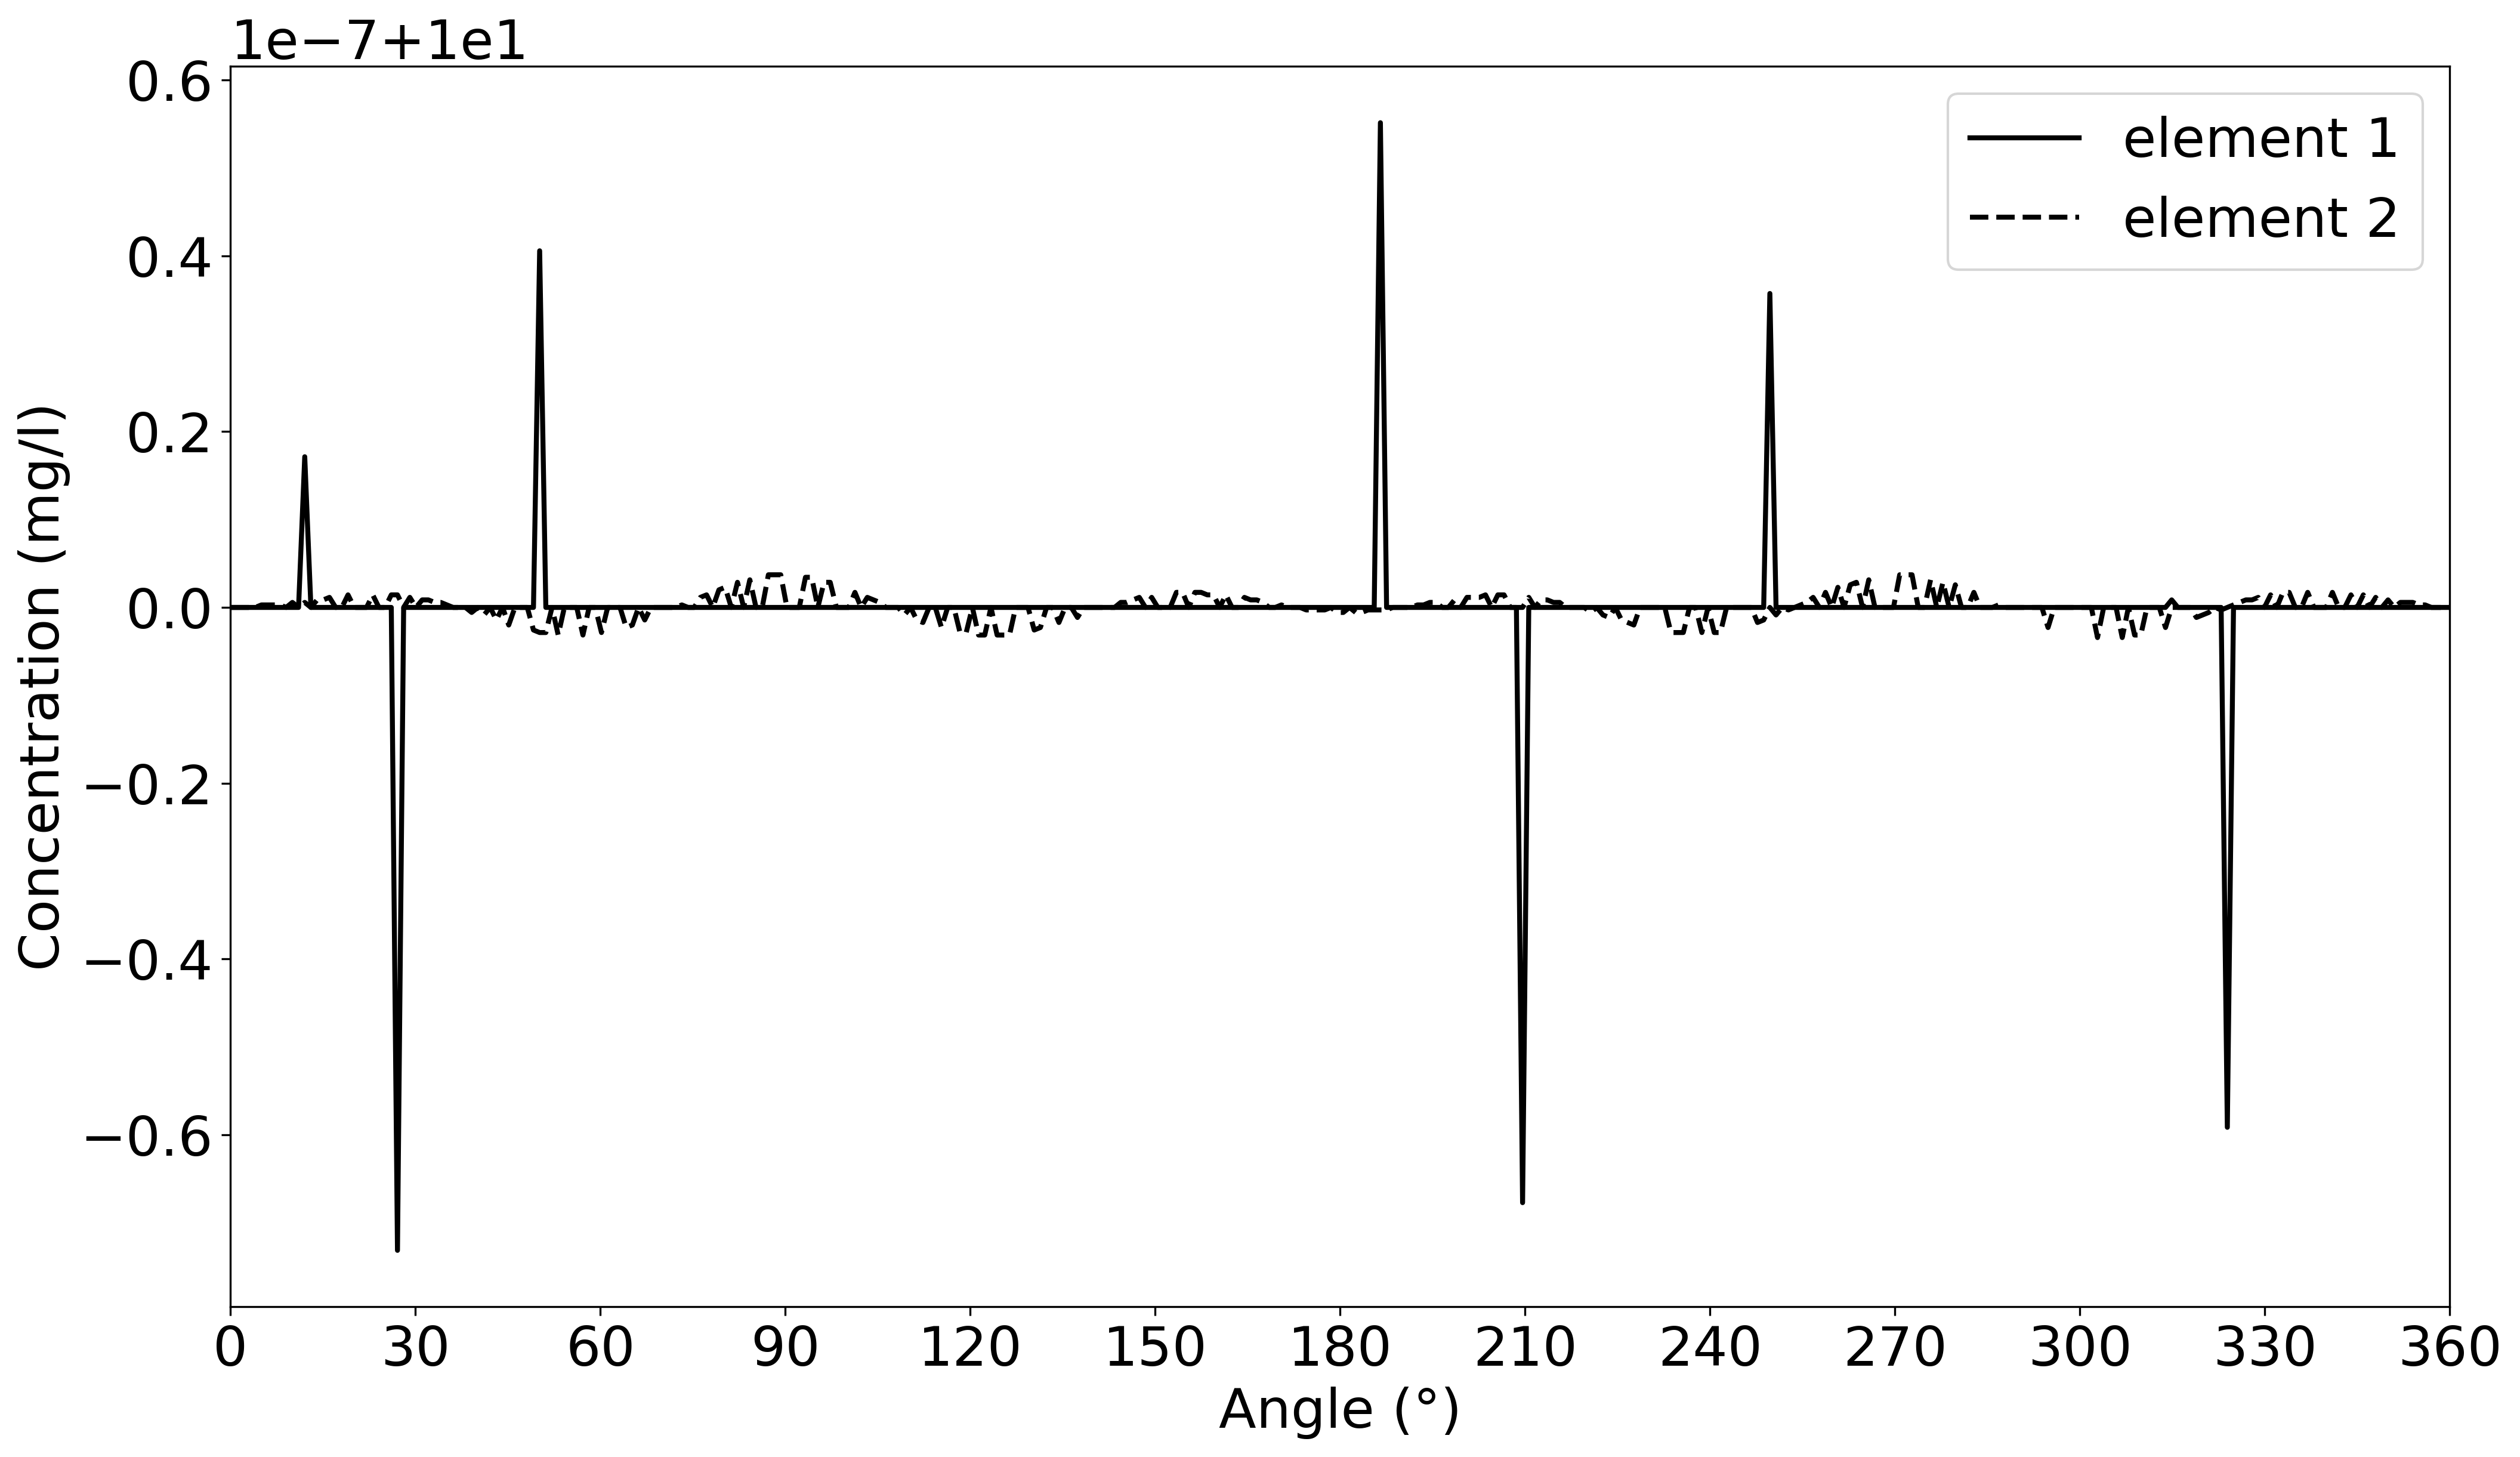

In [13]:
#absolut error [mg/l]
phi2 = np.linspace(0, 2*np.pi, 360)
x_test = (r + 0) * np.cos(phi2)
y_test = (r + 0) * np.sin(phi2)

x2_test = x_test+D1
y2_test = y_test+D2

Err = []
Err2 = []
for i in range(0,360,1):
    Err.append((c_multi(x_test[i], y_test[i])-Ca)/gamma)
    Err2.append((c_multi(x2_test[i], y2_test[i])-Ca)/gamma)
#print(Err)
#print(Err2)
print('Min =',np.min(Err).round(9))
print('Max =',np.max(Err).round(9))
print('Mean =',np.mean(Err).round(9))
print('Standard Deviation =',np.std(Err).round(9))
print('Min2 =',np.min(Err2).round(9))
print('Max2 =',np.max(Err2).round(9))
print('Mean2 =',np.mean(Err2).round(9))
print('Standard Deviation2 =',np.std(Err2).round(9))

plt.figure(figsize=(16,9), dpi=300)
mpl.rcParams.update({'font.size': 22})
plt.plot(phi2,Err, color='black', linewidth=2, label='element 1')
plt.plot(phi2,Err2, color='black', linewidth=2, linestyle = '--', label='element 2')
plt.xlim([0, 2*np.pi])
plt.xlabel('Angle (°)')
plt.ylabel('Concentration (mg/l)')
plt.xticks(np.linspace(0, 2*np.pi, 13), np.linspace(0, 360, 13).astype(int))
plt.legend()

# Numerical Model

In [14]:
#Domain

Lx = 200
ncol = int(Lx/1)
Ly = 51
nrow = int(Ly/1)

nlay=1

#calculate BC input for numerical model at domain extent: -150<x<450; -100<y<100
upper_lower_bc = []
for i in range(int(-(0.25*Lx)), int(0.75*Lx)):
    upper_lower_bc.append(c_single(i, 0.5*(Ly-1)))
left_bc = []
for i in range(int(-0.5*(Ly-1)), int(0.5*(Ly+1))):
    left_bc.append(c_single(-(0.25*Lx), i))
right_bc = []
for i in range(int(-0.5*(Ly-1)), int(0.5*(Ly+1))):
    right_bc.append(c_single(0.75*Lx, i))

#Parameter

prsity = 0.3
al = 10
ath = al*0.1
Gamma = 3.5
Cd = 10
Cd2 = 10
Ca = 8
h1 = 100
h2 = 1
hk = 1e-4

In [15]:
#Exe

exe_name_mf = 'mf2005.exe'
exe_name_mt = 'mt3dms.exe'

In [16]:
#Flow Calculation

mf = flopy.modflow.Modflow(modelname='T02_mf', exe_name=exe_name_mf)
dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, delr=Lx/ncol, delc=Ly/nrow, top=0, botm=-1, itmuni=1, perlen = 1e8)

ibound=np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:,:,0] = -1
ibound[:,:,-1] = -1
strt=np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:,:,0] = h1
strt[:,:,-1] = h2

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=0)
gmg = flopy.modflow.ModflowGmg(mf)
lmt = flopy.modflow.ModflowLmt(mf)

mf.write_input()
mf.run_model(silent=True)

(True, [])

In [17]:
#Transport Calculation

mt = flopy.mt3d.Mt3dms(modelname='T02_mt', exe_name=exe_name_mt, modflowmodel=mf)

icbund = np.ones((nlay, nrow, ncol), dtype=np.int32)

icbund[:,:,0] = -1
icbund[:,:,-1] = -1
icbund[:,0,:] = -1
icbund[:,-1,:] = -1

icbund[:,int(0.5*nrow)-1,int(0.25*ncol)-1:int(0.25*ncol)] = -1
icbund[:,int(0.5*nrow),int(0.25*ncol)-1:int(0.25*ncol)] = -1

#icbund[:,int(0.5*nrow)-11,int(0.25*ncol)+10:int(0.25*ncol)+11] = -1
#icbund[:,int(0.5*nrow)-10,int(0.25*ncol)+10:int(0.25*ncol)+11] = -1

sconc = np.zeros((nlay, nrow, ncol), dtype=np.float32)

sconc[:,:,0] = left_bc 
sconc[:,:,-1] = right_bc 
sconc[:,0,:] = upper_lower_bc 
sconc[:,-1,:] = upper_lower_bc 

sconc[:,int(0.5*nrow)-1,int(0.25*ncol)-1:int(0.25*ncol)] = (Gamma*Cd)+(Ca)
sconc[:,int(0.5*nrow),int(0.25*ncol)-1:int(0.25*ncol)] = (Gamma*Cd)+(Ca)

#sconc[:,int(0.5*nrow)-11,int(0.25*ncol)+10:int(0.25*ncol)+11] = (Gamma*Cd)+(Ca)
#sconc[:,int(0.5*nrow)-10,int(0.25*ncol)+10:int(0.25*ncol)+11] = (Gamma*Cd)+(Ca)


btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, ssflag=['sstate']) #, ssflag=['sstate']
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=0)
dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=ath/al)
gcg = flopy.mt3d.Mt3dGcg(mt)
ssm = flopy.mt3d.Mt3dSsm(mt)

mt.write_input()
mt.run_model(silent=True)

(False, [])

In [18]:
ucnobj = flopy.utils.UcnFile('MT3D001.UCN')
conc = ucnobj.get_alldata()
mvt = mt.load_mas('MT3D001.MAS')

C:\Users\Anton\anaconda3\Lib\site-packages\flopy\plot\map.py:241: UserWarning: The following kwargs were not used by contour: 'label'
  else ax.contour(xcentergrid, ycentergrid, plotarray, **kwargs)


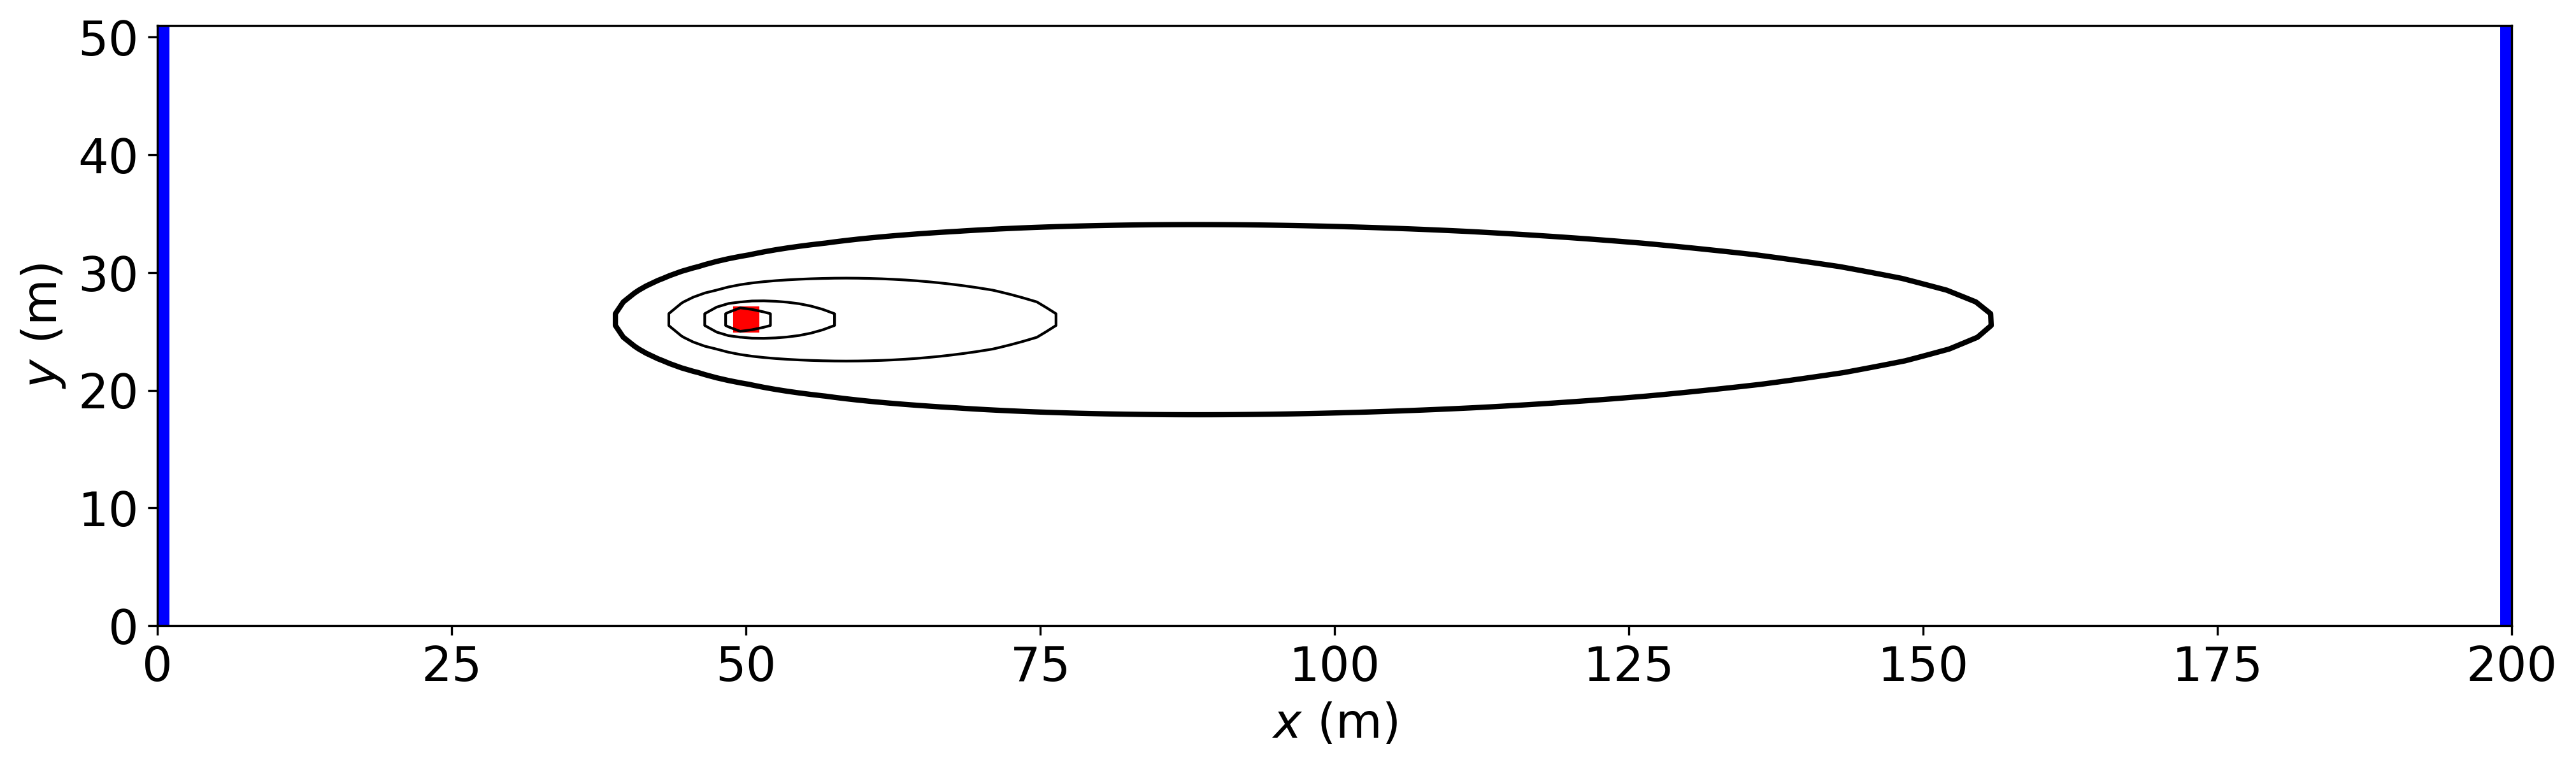

In [19]:
#Plot

C0=Ca
plt.figure(figsize=(16, 16*(Ly/Lx)), dpi=300)
plt.rcParams.update({'font.size': 18})
ax = plt.axes()
plt.axis('scaled')
mm = flopy.plot.map.PlotMapView(ax=ax, model=mf)
#mm.plot_grid(color='.5', alpha=0.2)
conc = conc[0, 0, :]
cs = mm.contour_array(conc, levels=np.linspace(15, (Gamma*Cd)+(Ca), 4), linewidths=1, colors='k')
cs_plume = mm.contour_array(conc, levels=[C0], linewidths=2, colors='k', label=r'$C_D = C_A = 0$')#np.linspace(C0, Gamma*Cd+C0, 5)
mm.plot_ibound()
plt.xlabel(r'$x$ (m)')
plt.ylabel(r'$y$ (m)')
Source = plt.Rectangle((0.25*Lx-1, 0.5*(Ly-1)), 2, 2, color = 'r')
plt.gca().add_patch(Source)

#plt.text(175,45, r'$\Delta x = 1 $m')
#plt.text(175,40, r'$\Delta y = 1 $m')
#rectangle = plt.Rectangle((174, 38), 20, 12, facecolor='lightgrey', edgecolor='black', linewidth=1)
#plt.gca().add_patch(rectangle)
#plt.clabel(cs_plume, inline = True, fmt=r'$C_D = C_A = 0$')
#plt.title('Contaminant Plume')

In [20]:
#Plume length

p1 = cs_plume.collections[0].get_paths()[0]
coor_p1 = p1.vertices
np.max(coor_p1[:,0])-np.min(coor_p1[:,0])

C:\Users\Anton\AppData\Local\Temp\ipykernel_439596\1750840616.py:3: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  p1 = cs_plume.collections[0].get_paths()[0]


116.87269076436765